In [1]:
import numpy as np
import time
import utils
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import model
import torch.optim as optim

/home/adam/anaconda3/envs/pytorch3d_new/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_model = True

In [3]:
data_file = r"/media/adam/HDD_2/Datasets/NURBS_Geometry/IJAC/poly_surface_v1/PointCloud/poly_surface_v1_point_cloud_All.npy" # path to the pointclouds file

batch_size = 32
output_folder = r"/media/adam/HDD_2/Datasets/NURBS_Geometry/IJAC/poly_surface_v1/_models" # folder path to save the results
save_results = False # save the results to output_folder
use_GPU = True # use GPU, False to use CPU
latent_size = 128 # bottleneck size of the Autoencoder model

geo_save_folder =r"/media/adam/HDD_2/Datasets/NURBS_Geometry/IJAC/poly_surface_v1/_models/_geometries"
export_geo_name = "Pointcloud_3_1000"

epochs = 300
show_plots_during_training = False
save_model = True
model_name = "pointcloud_poly_surface_v1_"

In [4]:
def visualize_pointcloud(pointcloud, color='b'):
 
    #check if pointcloud in pytorch tensor
    if isinstance(pointcloud, torch.Tensor):
        pointcloud = pointcloud.cpu().detach().numpy()
    
    #check if pointcloud in numpy array
    if isinstance(pointcloud, np.ndarray):
        pointcloud = pointcloud
    else:
        raise ValueError("pointcloud type not supported; must be numpy array or pytorch tensor")
    
    assert len(pointcloud.shape) == 2, "must be 2D array"

    if pointcloud.shape[0] != 3:
        pointcloud = pointcloud.T
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pointcloud[0, :], pointcloud[1, :], pointcloud[2, :], c=color, marker='o')
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Yxis')
    ax.set_zlabel('Z Zxis')
    plt.show()

In [5]:
from Dataloaders import GetDataLoaders

#pc_array = np.load("data/chair_set.npy")
pc_array = np.load(data_file)
print(pc_array.shape)

# load dataset from numpy array and divide 90%-10% randomly for train and test sets
train_loader, test_loader = GetDataLoaders(npArray=pc_array, batch_size=batch_size)

# Assuming all models have the same size, get the point size from the first model
point_size = len(train_loader.dataset[0])
print(point_size)

(4899, 1000, 3)
1000


torch.Size([1000, 3])


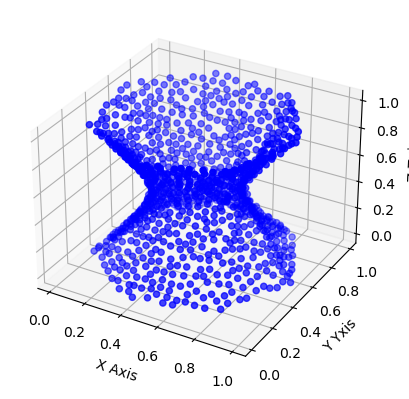

In [6]:
# visualize a random pointcloud
# get a random pointcloud from the dataset
random_index = np.random.randint(0, len(train_loader.dataset))

random_pointcloud = train_loader.dataset[random_index]
print(random_pointcloud.shape)
visualize_pointcloud(train_loader.dataset[random_index])

In [7]:
net = model.PointCloudAE(point_size,latent_size)

if(use_GPU):
    device = torch.device("cuda:0")
    if torch.cuda.device_count() > 1: # if there are multiple GPUs use all
        net = torch.nn.DataParallel(net)
else:
    device = torch.device("cpu")

net = net.to(device)
print("Number of parameters: ", sum(p.numel() for p in net.parameters()))
print("Number of layers: ", len(list(net.parameters())))

Number of parameters:  895544
Number of layers:  18


In [8]:
from pytorch3d.loss import chamfer_distance # chamfer distance for calculating point cloud distance

optimizer = optim.Adam(net.parameters(), lr=0.0005)

In [9]:
def train_epoch():
    epoch_loss = 0
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        
        data = data.to(device)
        output = net(data.permute(0,2,1)) # transpose data for NumberxChannelxSize format
        loss, _ = chamfer_distance(data, output) 
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss/i

In [10]:
def test_batch(data): # test with a batch of inputs
    with torch.no_grad():
        data = data.to(device)
        output = net(data.permute(0,2,1))
        loss, _ = chamfer_distance(data, output)
        
    return loss.item(), output.cpu()

In [11]:
def test_epoch(): # test with all test set
    with torch.no_grad():
        epoch_loss = 0
        for i, data in enumerate(test_loader):
            loss, output = test_batch(data)
            epoch_loss += loss

    return epoch_loss/i

In [12]:
if(save_results):
    utils.clear_folder(output_folder)

epoch 0 train loss : 0.01565992514378507 test loss : 0.005013136100023985 epoch time : 0.7845039367675781

epoch 1 train loss : 0.003838076536632041 test loss : 0.003721933811903 epoch time : 0.3300323486328125

epoch 2 train loss : 0.0029437653397475063 test loss : 0.003059989803781112 epoch time : 0.3442115783691406

epoch 3 train loss : 0.0027473768674816093 test loss : 0.002911741224428018 epoch time : 0.331601619720459

epoch 4 train loss : 0.0026505323327452378 test loss : 0.002703449440499147 epoch time : 0.36450648307800293

epoch 5 train loss : 0.002478261908217177 test loss : 0.0026654889962325493 epoch time : 0.31832027435302734

epoch 6 train loss : 0.0023292575293240975 test loss : 0.002581378429507216 epoch time : 0.31835317611694336

epoch 7 train loss : 0.0022464532245385603 test loss : 0.002825658240665992 epoch time : 0.31700706481933594

epoch 8 train loss : 0.0022330411767627852 test loss : 0.0023132390963534516 epoch time : 0.31775951385498047

epoch 9 train loss :

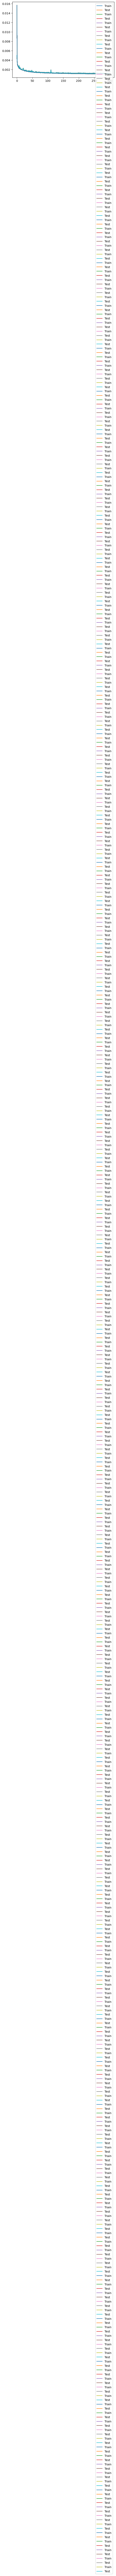

In [13]:
if train_model == True:
    train_loss_list = []  
    test_loss_list = []  

    for i in range(epochs) :

        startTime = time.time()
        
        train_loss = train_epoch() #train one epoch, get the average loss
        train_loss_list.append(train_loss)
        
        test_loss = test_epoch() # test with test set
        test_loss_list.append(test_loss)
        
        epoch_time = time.time() - startTime
        
        writeString = "epoch " + str(i) + " train loss : " + str(train_loss) + " test loss : " + str(test_loss) + " epoch time : " + str(epoch_time) + "\n"
        
        # plot train/test loss graph
        plt.plot(train_loss_list, label="Train")
        plt.plot(test_loss_list, label="Test")
        plt.legend()

        if(save_results): # save all outputs to the save folder

            # write the text output to file
            with open(output_folder + "prints.txt","a") as file: 
                file.write(writeString)

            # update the loss graph
            plt.savefig(output_folder + "loss.png")
            plt.close()

            # save input/output as image file
            if(i%50==0):
                test_samples = next(iter(test_loader))
                loss , test_output = test_batch(test_samples)
                utils.plotPCbatch(test_samples, test_output, show=False, save=True, name = (output_folder  + "epoch_" + str(i)))

        else : # display all outputs
            
            test_samples = next(iter(test_loader))
            loss , test_output = test_batch(test_samples)

            if show_plots_during_training:
                utils.plotPCbatch(test_samples,test_output)

            print(writeString)

            if show_plots_during_training:
                plt.show()

    # plot train/test loss graph
    plt.plot(train_loss_list)

        


In [14]:
if train_model == True:
    if(save_model):
            torch.save(net, output_folder + model_name +"model.pth")
            #model_scripted = torch.jit.script(net)
            #model_scripted.save(output_folder + model_name +"model.pt")

Original Point Cloud


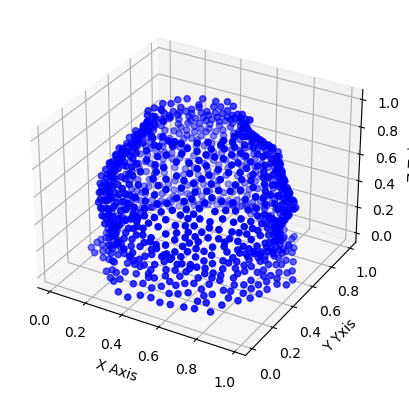

Reconstructed Point Cloud


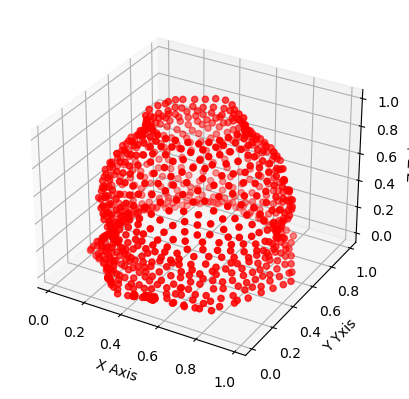

In [15]:
if train_model == True:
    # make reconstruction of a single point cloud
    test_samples = next(iter(test_loader))
    loss , test_output = test_batch(test_samples)

    #utils.plotPCbatch(test_samples,test_output)

    print("Original Point Cloud")
    visualize_pointcloud(test_samples[0])

    print("Reconstructed Point Cloud")
    visualize_pointcloud(test_output[0], color='r')


In [16]:
# load the trained model for testing
loaded_model = torch.load(output_folder + model_name +"model.pth")
loaded_model.eval()

PointCloudAE(
  (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
  (conv3): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dec1): Linear(in_features=128, out_features=256, bias=True)
  (dec2): Linear(in_features=256, out_features=256, bias=True)
  (dec3): Linear(in_features=256, out_features=3000, bias=True)
)

torch.Size([101, 1000, 3])
torch.Size([101, 1000, 3])
Original Point Cloud


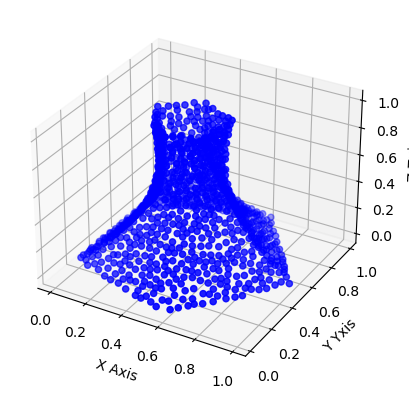

Reconstructed Point Cloud


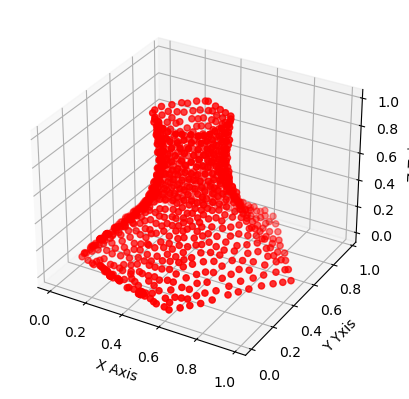

(101, 1000, 3)
Saved as numpy array to:  /media/adam/HDD_2/Datasets/NURBS_Geometry/IJAC/poly_surface_v1/_models/_geometries/Pointcloud_3_1000.npy


In [17]:
withheld_test_data_path = r"/media/adam/HDD_2/Datasets/NURBS_Geometry/IJAC/_TestDATA_Poly_Surface/PointCloud/poly_surface_v1_NURBS_.npy"
pc_test_array = np.load(withheld_test_data_path)


#convert to torch tensor
pc_test_array = torch.tensor(pc_test_array).float()
print(pc_test_array.shape)

# perform testing on the withheld test data
_, pc_recon_test_array = test_batch(pc_test_array)
print(pc_recon_test_array.shape)

print("Original Point Cloud")
visualize_pointcloud(pc_test_array[0])
print("Reconstructed Point Cloud")
visualize_pointcloud(pc_recon_test_array[0], color='r')

recon_np = pc_recon_test_array.cpu().detach().numpy()
print(recon_np.shape)
#save as numpy arrays
np.save(geo_save_folder +"/"+  export_geo_name +".npy", recon_np)
print("Saved as numpy array to: ", geo_save_folder +"/"+  export_geo_name +".npy")



In [18]:
def calculate_similarity(tensor1: torch.Tensor, tensor2: torch.Tensor) -> float:
    """
    Calculate a similarity score between two tensors.
    
    Args:
    - tensor1 (torch.Tensor): The first input tensor.
    - tensor2 (torch.Tensor): The second input tensor.
    
    Returns:
    - float: The similarity score.
    """
    # Ensure the tensors have the same shape
    if tensor1.shape != tensor2.shape:
        raise ValueError("The input tensors must have the same shape.")
    
    # flatten the tensors
    tensor1 = tensor1.view(-1)
    tensor2 = tensor2.view(-1)

    # Calculate the Mean Squared Error (MSE)
    mse = torch.mean((tensor1 - tensor2) ** 2)
    
    # Normalize by the number of features and elements

    num_elements = tensor1.numel()
    num_features = tensor1.shape[-1] if len(tensor1.shape) > 1 else 1

    print("num_elements in each tensor: ", num_elements)
    print("num_features in each tensor: ", num_features)
    
    normalized_mse = mse / (num_elements * num_features)
    
    # Calculate the similarity score (1 - normalized MSE)
    similarity_score = 1 - normalized_mse.item()
    
    return similarity_score

similarity_score = calculate_similarity(pc_test_array, pc_recon_test_array)
print("Similarity score: ", similarity_score)
#export the similarity score as text file
with open(geo_save_folder +"/"+  export_geo_name + "_similarity_score.txt", "w") as file:
    file.write(str(similarity_score))

num_elements in each tensor:  303000
num_features in each tensor:  1
Similarity score:  0.9999994813714466
